In [38]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from collections import Counter
from nltk.corpus import gutenberg, stopwords
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import ensemble
from sklearn.model_selection import train_test_split

In [2]:
import re
import spacy
from urllib import request

class GutenbergBookChapters():
    def __init__(self, author, title, url, chLimit=10):
        self.contents = self._loadFileFromGutenberg(author, title, url)
        self.lines = self._getLines()
        self.headings = self._getHeadings()
        self.headingLocations = self.headings
        self._ignoreTOC()
        self.chapters = self._getTextBetweenHeadings()
        self.numChapters = len(self.chapters)
        self._setChapters(chLimit)
        self._setSentences()
    
    def _loadFileFromGutenberg(self,author, title, url):
        self.author = author
        self.title = title
        self.url = url
        response = request.urlopen(self.url)
        contents = response.read().decode('utf8')
        return contents
    
    def _getContents(self):
        """
        Reads the book into memory.
        """
        contents = gutenberg.raw(self.filename)
        return contents

    def _getLines(self):
        """
        Breaks the book into lines.
        """
        return self.contents.split('\n')

    def _getHeadings(self):

        # Form 1: Chapter I, Chapter 1, Chapter the First, CHAPTER 1
        # Ways of enumerating chapters, e.g.
        arabicNumerals = '\d+'
        romanNumerals = '(?=[MDCLXVI])M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})'
        numberWordsByTens = ['twenty', 'thirty', 'forty', 'fifty', 'sixty',
                              'seventy', 'eighty', 'ninety']
        numberWords = ['one', 'two', 'three', 'four', 'five', 'six',
                       'seven', 'eight', 'nine', 'ten', 'eleven',
                       'twelve', 'thirteen', 'fourteen', 'fifteen',
                       'sixteen', 'seventeen', 'eighteen', 'nineteen'] + numberWordsByTens
        numberWordsPattern = '(' + '|'.join(numberWords) + ')'
        ordinalNumberWordsByTens = ['twentieth', 'thirtieth', 'fortieth', 'fiftieth', 
                                    'sixtieth', 'seventieth', 'eightieth', 'ninetieth'] + \
                                    numberWordsByTens
        ordinalNumberWords = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth', 
                              'seventh', 'eighth', 'ninth', 'twelfth', 'last'] + \
                             [numberWord + 'th' for numberWord in numberWords] + ordinalNumberWordsByTens
        ordinalsPattern = '(the )?(' + '|'.join(ordinalNumberWords) + ')'
        enumeratorsList = [arabicNumerals, romanNumerals, numberWordsPattern, ordinalsPattern] 
        enumerators = '(' + '|'.join(enumeratorsList) + ')'
        form1 = 'chapter ' + enumerators

        # Form 2: II. The Mail
        enumerators = romanNumerals
        separators = '(\. | )'
        titleCase = '[A-Z][a-z]'
        form2 = enumerators + separators + titleCase

        # Form 3: II. THE OPEN ROAD
        enumerators = romanNumerals
        separators = '(\. )'
        titleCase = '[A-Z][A-Z]'
        form3 = enumerators + separators + titleCase

        # Form 4: a number on its own, e.g. 8, VIII
        arabicNumerals = '^\d+\.?$'
        romanNumerals = '(?=[MDCLXVI])M{0,3}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})\.?$'
        enumeratorsList = [arabicNumerals, romanNumerals]
        enumerators = '(' + '|'.join(enumeratorsList) + ')'
        form4 = enumerators

        pattern = re.compile(form1, re.IGNORECASE)
        # This one is case-sensitive.
        pattern2 = re.compile('(%s|%s|%s)' % (form2, form3, form4))

        headings = []
        for i, line in enumerate(self.lines):
            if pattern.match(line) is not None:
                headings.append(i)
            if pattern2.match(line) is not None:
                headings.append(i)

        if len(headings) < 3:
            print('Headings: %s' % headings)
            print("Detected fewer than three chapters. This probably means there's something wrong with chapter detection for this book.")
            exit()

        self.endLocation = self._getEndLocation()

        # Treat the end location as a heading.
        headings.append(self.endLocation)

        return headings

    def _ignoreTOC(self):
        """
        Filters headings out that are too close together,
        since they probably belong to a table of contents.
        """
        pairs = zip(self.headingLocations, self.headingLocations[1:])
        toBeDeleted = []
        for pair in pairs:
            delta = pair[1] - pair[0]
            if delta < 4:
                if pair[0] not in toBeDeleted:
                    toBeDeleted.append(pair[0])
                if pair[1] not in toBeDeleted:
                    toBeDeleted.append(pair[1])
        #print('TOC locations to be deleted: %s' % toBeDeleted)
        for badLoc in toBeDeleted:
            index = self.headingLocations.index(badLoc)
            del self.headingLocations[index]

    def _getEndLocation(self):
        """
        Tries to find where the book ends.
        """
        ends = ["End of the Project Gutenberg EBook",
                "End of Project Gutenberg's",
                "\*\*\*END OF THE PROJECT GUTENBERG EBOOK",
                "\*\*\* END OF THIS PROJECT GUTENBERG EBOOK"]
        joined = '|'.join(ends)
        pattern = re.compile(joined, re.IGNORECASE)
        endLocation = None
        for line in self.lines:
            if pattern.match(line) is not None:
                endLocation = self.lines.index(line)
                self.endLine = self.lines[endLocation]
                break

        if endLocation is None: # Can't find the ending.
            #print("Can't find an ending line. Assuming that the book ends at the end of the text.")
            endLocation = len(self.lines)-1 # The end
            self.endLine = 'None'

        #print('End line: %s at line %s' % (self.endLine, endLocation))
        return endLocation

    def _getTextBetweenHeadings(self):
        chapters = []
        lastHeading = len(self.headingLocations) - 1
        for i, headingLocation in enumerate(self.headingLocations):
            if i is not lastHeading:
                nextHeadingLocation = self.headingLocations[i+1]
                chapters.append(self.lines[headingLocation+1:nextHeadingLocation])
        return chapters

    def _zeroPad(self, numbers):
        """
        Takes a list of ints and zero-pads them, returning
        them as a list of strings.
        """
        maxNum = max(numbers)
        maxDigits = len(str(maxNum))
        numberStrs = [str(number).zfill(maxDigits) for number in numbers]
        return numberStrs

    def _setChapters(self,chLimit):
        """
        Creates data set for chapters
        """
        chapterNums = self._zeroPad(range(1, len(self.chapters)+1))
        
        # chapters as list of lines from orig doc
        self.df_chText = pd.DataFrame([[self.author,self.title,num, len(chapter),chapter] for num,chapter in zip(chapterNums, self.chapters)])
        self.df_chText.columns=['author','title','chapter','size','chLineList']
        
        if chLimit:
            # limit chapters to just the biggest ones
            self.df_chText.sort_values(by=['size'])
            self.df_chText = self.df_chText.sort_values(by=['size'], ascending=False)[:chLimit]
            self.df_chText = self.df_chText.reset_index(drop=True)
            
        # chapters converted to doc format (rather than list) for easier processing
        self.df_chText['chDoc'] = self.df_chText.chLineList.apply(lambda x: ''.join(x))

        # handle cleaning that spacy misses before tokenizing 
        self.df_chText['chTokens'] = self._preTokenizeClean(self.df_chText.chDoc)
        
        nlp = spacy.load('en')
        self.df_chText['chTokens'] = self.df_chText.chTokens.apply(lambda x: nlp(x))
    
        # clean and process
        self.df_chText['chCleanSentList'] = self.df_chText.chTokens.apply(lambda x: self._cleanAndProcess(x))
        
    def _preTokenizeClean(self,dfToClean):
        """
        Clean up the text that spacy misses using regular expression
        matching.  Most of these have been selected after viewing the 
        spacy text.
        """
        # patterns to match and string to replace them with
        patternAndReplace = {
            '--': ' ',
            '.\"': '. ',
            ';': '; ',  
            '_': ' ',
            '\'s': ' ',
            '\\r': ' '
            }
        for pattern, replacement in patternAndReplace.items():
            dfToClean = dfToClean.apply(lambda x: re.sub(pattern,replacement, x))
        return dfToClean
        
    
    def _cleanAndProcess(self, tokenizedCh):
        """
        Whatever is needed to get to comparable form
        clean, lemmanize, remove suffix, etc. 
        
        Sets list of common words for bag of words
        
        Returns a list of clean sentences and words (for bag of words)
        """
        processedSentList = []
        allWords = []
        for sent in tokenizedCh.sents:
            #print ("sent: {}".format(sent))
            newSent = []
            for word in sent:
                # remove blanks
                if word.text == ' ':
                    continue 
                # remove puntuation
                if word.is_punct:
                    continue
                # remove stop words
                if word.is_stop:
                    continue
                # lemmatize
                word = word.lemma_
                # remove pronouns
                if word == '-PRON-':
                    continue
                # remove '.' from words like 'Mr.'
                word = re.sub(r'\.','', word)
                # store word
                newSent.append(word)
                # collecting all the words since we are going through them anyway
                allWords.append(word)
            if newSent:
                processedSentList.append(' '.join(newSent))      
            
        # get most common words
        self.commonWords = [w[0] for w in Counter(allWords).most_common(2000)]
        
        return processedSentList
        
    
    def _setSentences(self):
        """
        Create a data set of sentences and author to be combined with 
        other lists of sentences and authors
        """
        self.df_sentences = pd.DataFrame()
        for row in self.df_chText['chCleanSentList']:
            dfNext = pd.DataFrame(pd.DataFrame(np.array(row).reshape(len(row)), columns=['sentence']))
            self.df_sentences = self.df_sentences.append(dfNext)
        self.df_sentences['author'] = self.author
        
    def generateBagOfWords(self, GBCbooksList):
        """
        Takes a list of GutenbergBookChapters objects and returns
        a Bag or Words DataSet made up of books from list and this
        book
        """
        GBCbooksList.append(self)
        # create a set of the most common words
        wordsFromBooks = []
        for books in GBCbooksList:
            wordsFromBooks.extend(GBCbooksList.commonWords)
            
        
        # create a data frame of the most common words
        
    def generateSentenceDf(self, GBCbooksList):
        """
        Takes a list of GutenbergBookChapters objects and returns
        a DataSet of authors, bookand sentences made up of books from 
        list and this book
        """
        return

In [25]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import math
import time

class ClusterModel(object):
    
    def __init__ (self,name, dfData, modelObj, catCols=None, contCols=None, **modelParams):
        self.name = name
        self.X = dfData
        self.modelParams = modelParams
        self.modelObj = modelObj.set_params(**self.modelParams)
        self.contCols = contCols
        self.catCols = catCols
        self.initValues()
        self.initSilhouette()
        
    def initValues(self):
        self.Xnorm = normalize(self.X)
        start = time.time()
        self.modelFit = self.modelObj.fit(self.Xnorm)
        end = time.time()
        self.timeToFit = end - start
        self.Xclust = self.X.copy()
        self.Xclust['cluster'] = self.modelFit.labels_

    def initSilhouette(self):
        XA, XB = train_test_split(
        self.Xnorm,
        test_size=0.5,
        random_state=42)

        X1, X2 = train_test_split(
            XA,
            test_size=0.5,
            random_state=42)

        X3, X4 = train_test_split(
            XB,
            test_size=0.5,
            random_state=42)

        self.silScores = []
        for sample in [X1, X2, X3, X4]:
            modelSample = self.modelObj.fit(sample)
            labels = modelSample.labels_
            silScore = metrics.silhouette_score(sample, labels, metric='euclidean')
            self.silScores.append(silScore)
        self.silScoreMean = np.mean(self.silScores)
        self.silScoreRange = max(self.silScores) - min(self.silScores)
   
    def silScore(self):
        print ("MEAN: {}".format(self.silScoreMean))
        print ("RANGE: {}".format(self.silScoreRange))
        print ("SCORES: {}".format(self.silScores))
       
    def showCatGraphs(self):
        for cat in self.catCols:
            sns.set(style="whitegrid")
            g = sns.catplot(x='cluster',
                hue=cat,
                data=self.Xclust,kind='count')
            plt.show()
    
    def showContBoxPlots(self,gridCols=2):
        numOfCols = len(self.contCols)
        rows = math.ceil(numOfCols/2)
        
        for catCol in self.catCols:
            fig = plt.figure(figsize=(30,80))
            for idx,contCol in enumerate(self.contCols):
                ax = fig.add_subplot(rows, gridCols, idx+1)
                ax.set_title("\"{}\"per Cluster".format(contCol))
                ax.yaxis.label.set_size(25)
                ax.yaxis.set_tick_params(labelsize = 20)
                ax.xaxis.label.set_size(25)
                ax.xaxis.set_tick_params(labelsize = 20)
                sns.boxplot(y=contCol,
                        x='cluster', 
                        hue=catCol,
                        palette="Set2",
                        data=self.Xclust, ax=ax)
            plt.show()
    
    def compareBox(self,modelList,filterResult=0, newTitle=''):
        results = []
        names = []
        
        results.append(self.silScores)
        names.append(self.name)
        
        for rightModel in modelList:
            results.append(rightModel.silScores)
            names.append(rightModel.name)
        
        fig = plt.figure()
        if newTitle != '':
            title = newTitle
        else:
            title = "Performance: %s" % (self.name)
        fig.suptitle(title)
        ax = fig.add_subplot(111)
        
        plt.boxplot(results, showmeans=True)
        ax.set_xticklabels(names)
        plt.setp(ax.get_xticklabels(), rotation=90)
        plt.show()
        
    def fullCompareList(self,listOfModels,dist=True):
        listOfModels.insert(0,self)
        dfout = pd.DataFrame()
        dataForFrame = []
        slNameList= []
        for model in listOfModels:
            dataRowForFrame = {}
            dataRowForFrame = {'Name': model.name,
                                'Time':model.timeToFit,
                                'Sil Mean':model.silScoreMean,
                                'Sil Range': model.silScoreRange}
            if dist:  
                buildSlNameList = False
                if not slNameList:
                    buildSlNameList=True
                for idx,sl in enumerate(model.silScores):
                    slName = 'Dist ' + str(idx+1)
                    if buildSlNameList:
                        slNameList.append(slName)
                    dataRowForFrame[slName] = sl
            dataForFrame.append(dataRowForFrame)
        colOrder = ['Name', 'Sil Mean', 'Sil Range', 'Time']
        colOrder += slNameList  
        dfOut = pd.DataFrame(dataForFrame)
        dfOut = dfOut[colOrder]
        display(dfOut)
        lgrbg = listOfModels.pop(0)
        self.compareBox(listOfModels) 

In [4]:

dfBooks = pd.DataFrame(pd.np.empty((0, 3)))
dfBooks.columns=['author','title','url']
dfBooks.loc[len(dfBooks)] = ['twain', 'sawyer', 'https://www.gutenberg.org/files/74/74-0.txt']
dfBooks.loc[len(dfBooks)] = ['austen', 'pride', 'https://www.gutenberg.org/files/1342/1342-0.txt']
dfBooks.loc[len(dfBooks)] = ['carroll', 'alice', 'https://www.gutenberg.org/files/11/11-0.txt']

dfBooks.loc[len(dfBooks)] = ['melville', 'moby', 'https://www.gutenberg.org/files/2701/2701-0.txt']
dfBooks.loc[len(dfBooks)] = ['doyle', 'holmes', 'https://www.gutenberg.org/ebooks/1661.txt.utf-8']
dfBooks.loc[len(dfBooks)] = ['dickens', 'tale', 'https://www.gutenberg.org/files/98/98-0.txt']
dfBooks.loc[len(dfBooks)] = ['stoker', 'dracula', 'https://www.gutenberg.org/ebooks/345.txt.utf-8']
dfBooks.loc[len(dfBooks)] = ['barrie', 'pan', 'https://www.gutenberg.org/files/16/16-0.txt']
dfBooks.loc[len(dfBooks)] = ['wilde', 'dorian', 'https://www.gutenberg.org/ebooks/174.txt.utf-8']
dfBooks.loc[len(dfBooks)] = ['shelley', 'frankenstein', 'https://www.gutenberg.org/files/84/84-0.txt']

dfBooks

,author,title,url
0,twain,sawyer,https://www.gutenberg.org/files/74/74-0.txt
1,austen,pride,https://www.gutenberg.org/files/1342/1342-0.txt
2,carroll,alice,https://www.gutenberg.org/files/11/11-0.txt
3,melville,moby,https://www.gutenberg.org/files/2701/2701-0.txt
4,doyle,holmes,https://www.gutenberg.org/ebooks/1661.txt.utf-8
5,dickens,tale,https://www.gutenberg.org/files/98/98-0.txt
6,stoker,dracula,https://www.gutenberg.org/ebooks/345.txt.utf-8
7,barrie,pan,https://www.gutenberg.org/files/16/16-0.txt
8,wilde,dorian,https://www.gutenberg.org/ebooks/174.txt.utf-8
9,shelley,frankenstein,https://www.gutenberg.org/files/84/84-0.txt


In [5]:
bookDict = {}
for index, book in dfBooks.iterrows():
    print (book['title'])
    bookGBC = GutenbergBookChapters(book.author, book.title, book.url)
    bookDict[bookGBC.author] = bookGBC

sawyer
pride
alice
moby
holmes
tale
dracula
pan
dorian
frankenstein


In [6]:
for author,bookChap in bookDict.items():
    print (author)
    display(bookChap.df_chText.head())

twain


,author,title,chapter,size,chLineList,chDoc,chTokens,chCleanSentList
0,twain,sawyer,06,509,"[\r, MONDAY morning found Tom Sawyer miserable...",\rMONDAY morning found Tom Sawyer miserable. M...,"( , MONDAY, morning, found, Tom, Sawyer, miser...","[monday morning find tom sawyer miserable, mon..."
1,twain,sawyer,33,416,"[\r, WITHIN a few minutes the news had spread,...","\rWITHIN a few minutes the news had spread, an...","( , WITHIN, a, few, minutes, the, news, had, s...",[within minute news spread dozen skiff load ma...
2,twain,sawyer,04,364,"[\r, THE sun rose upon a tranquil world, and b...","\rTHE sun rose upon a tranquil world, and beam...","( , THE, sun, rose, upon, a, tranquil, world, ...",[the sun rise tranquil world beam peaceful vil...
3,twain,sawyer,30,358,"[\r, AS the earliest suspicion of dawn appeare...",\rAS the earliest suspicion of dawn appeared o...,"( , AS, the, earliest, suspicion, of, dawn, ap...",[as early suspicion dawn appear sunday morning...
4,twain,sawyer,01,353,"[\r, “TOM!”\r, \r, No answer.\r, \r, “TOM!”\r,...",\r“TOM!”\r\rNo answer.\r\r“TOM!”\r\rNo answer....,"( , “, TOM, !, ”, , No, answer, ., , “, TOM,...","[tom, no answer, tom, no answer, what go boy ..."


austen


,author,title,chapter,size,chLineList,chDoc,chTokens,chCleanSentList
0,austen,pride,18,521,"[\r, \r, Till Elizabeth entered the drawing-ro...",\r\rTill Elizabeth entered the drawing-room at...,"( , Till, Elizabeth, entered, the, drawing, -...",[ till elizabeth enter drawing room netherfi...
1,austen,pride,43,506,"[\r, \r, Elizabeth, as they drove along, watch...","\r\rElizabeth, as they drove along, watched fo...","( , Elizabeth, ,, as, they, drove, along, ,, ...",[ elizabeth drive watch appearance pemberley...
2,austen,pride,47,426,"[\r, \r, “I have been thinking it over again, ...","\r\r“I have been thinking it over again, Eliza...","( , “, I, have, been, thinking, it, over, aga...",[ think elizabeth say uncle drive town consi...
3,austen,pride,16,359,"[\r, \r, As no objection was made to the young...",\r\rAs no objection was made to the young peop...,"( , As, no, objection, was, made, to, the, yo...",[ as objection young people engagement aunt ...
4,austen,pride,56,329,"[\r, \r, One morning, about a week after Bingl...","\r\rOne morning, about a week after Bingley's ...","( , One, morning, ,, about, a, week, after, B...",[ one morning week bingley engagement jane f...


carroll


,author,title,chapter,size,chLineList,chDoc,chTokens,chCleanSentList
0,carroll,alice,07,338,"[\r, There was a table set out under a tree in...",\rThere was a table set out under a tree in fr...,"( , There, was, a, table, set, out, under, a, ...",[there table set tree house march hare hatter ...
1,carroll,alice,06,316,"[\r, For a minute or two she stood looking at ...",\rFor a minute or two she stood looking at the...,"( , For, a, minute, or, two, she, stood, looki...",[for minute stand look house wonder suddenly f...
2,carroll,alice,09,316,"[\r, ‘You can’t think how glad I am to see you...",\r‘You can’t think how glad I am to see you ag...,"( , ‘, You, ca, n’t, think, how, glad, I, am, ...",[not think glad dear old thing!’ say duchess t...
3,carroll,alice,08,302,"[\r, A large rose-tree stood near the entrance...",\rA large rose-tree stood near the entrance of...,"( , A, large, rose, -, tree, stood, near, the,...",[a large rose tree stand near entrance garden ...
4,carroll,alice,10,298,"[\r, The Mock Turtle sighed deeply, and drew t...","\rThe Mock Turtle sighed deeply, and drew the ...","( , The, Mock, Turtle, sighed, deeply, ,, and,...","[the mock turtle sigh deeply draw flapper eye,..."


melville


,author,title,chapter,size,chLineList,chDoc,chTokens,chCleanSentList
0,melville,moby,057,814,"[\r, (_As told at the Golden Inn._)\r, \r, The...",\r(_As told at the Golden Inn._)\r\rThe Cape o...,"( , (, As, told, at, the, Golden, Inn, ., ), ...","[as tell golden inn, the cape good hope watery..."
1,melville,moby,004,569,"[\r, Entering that gable-ended Spouter-Inn, yo...","\rEntering that gable-ended Spouter-Inn, you f...","( , Entering, that, gable, -, ended, Spouter, ...",[enter gable end spouter inn find wide low str...
2,melville,moby,017,560,"[\r, In bed we concocted our plans for the mor...",\rIn bed we concocted our plans for the morrow...,"( , In, bed, we, concocted, our, plans, for, t...","[in bed concoct plan morrow, but surprise smal..."
3,melville,moby,139,488,"[\r, The morning of the third day dawned fair ...",\rThe morning of the third day dawned fair and...,"( , The, morning, of, the, third, day, dawned,...",[the morning day dawn fair fresh solitary nigh...
4,melville,moby,091,452,"[\r, The long and narrow peninsula of Malacca,...","\rThe long and narrow peninsula of Malacca, ex...","( , The, long, and, narrow, peninsula, of, Mal...",[the long narrow peninsula malacca extend sout...


doyle


,author,title,chapter,size,chLineList,chDoc,chTokens,chCleanSentList
0,doyle,holmes,1,6180,[ IX. The Adventure of the Engineer's Thumb\r...,IX. The Adventure of the Engineer's Thumb\r ...,"( , IX, ., The, Adventure, of, the, Engineer,...","[ ix, the adventure engineer thumb , x, t..."
1,doyle,holmes,3,1207,"[\r, On glancing over my notes of the seventy ...",\rOn glancing over my notes of the seventy odd...,"( , On, glancing, over, my, notes, of, the, se...",[on glance note seventy odd case year study me...
2,doyle,holmes,7,1151,"[\r, ""To the man who loves art for its own sak...","\r""To the man who loves art for its own sake,""...","(., To, the, man, who, loves, art, for, its, o...","[to man love art sake, remark sherlock holmes ..."
3,doyle,holmes,6,1128,"[\r, ""Holmes,"" said I as I stood one morning i...","\r""Holmes,"" said I as I stood one morning in o...","(., Holmes, ., , said, I, as, I, stood, one, ...","[holme, say stand morning bow window look stre..."
4,doyle,holmes,5,1025,"[\r, The Lord St. Simon marriage, and its curi...","\rThe Lord St. Simon marriage, and its curious...","( , The, Lord, St., Simon, marriage, ,, and, i...",[the lord st simon marriage curious terminatio...


dickens


,author,title,chapter,size,chLineList,chDoc,chTokens,chCleanSentList
0,dickens,tale,07,1120,"[\r, \r, Tellson's Bank by Temple Bar was an o...",\r\rTellson's Bank by Temple Bar was an old-fa...,"( , Tellson, , Bank, by, Temple, Bar, was, a...",[ tellson bank temple bar old fashioned plac...
1,dickens,tale,32,1073,"[\r, \r, The dread tribunal of five Judges, Pu...","\r\rThe dread tribunal of five Judges, Public ...","( , The, dread, tribunal, of, five, Judges, ,...",[ the dread tribunal judges public prosecuto...
2,dickens,tale,34,628,"[\r, \r, “I, Alexandre Manette, unfortunate ph...","\r\r“I, Alexandre Manette, unfortunate physici...","( , “, I, ,, Alexandre, Manette, ,, unfortuna...","[ , alexandre manette unfortunate physician n..."
3,dickens,tale,33,556,"[\r, \r, While Sydney Carton and the Sheep of ...",\r\rWhile Sydney Carton and the Sheep of the p...,"( , While, Sydney, Carton, and, the, Sheep, o...",[ while sydney carton sheep prison adjoining...
4,dickens,tale,37,556,"[\r, \r, In the black prison of the Concierger...","\r\rIn the black prison of the Conciergerie, t...","( , In, the, black, prison, of, the, Concierg...",[ in black prison conciergerie doom day awai...


stoker


,author,title,chapter,size,chLineList,chDoc,chTokens,chCleanSentList
0,stoker,dracula,54,805,"[\r, MINA HARKER'S JOURNAL\r, \r, \r, _1 Novem...",\rMINA HARKER'S JOURNAL\r\r\r_1 November._--Al...,"( , MINA, HARKER, 'S, JOURNAL, , 1, Novembe...","[mina harker 's journal , 1 november, all d..."
1,stoker,dracula,39,713,"[\r, DR. SEWARD'S DIARY\r, \r, \r, _18 Septemb...",\rDR. SEWARD'S DIARY\r\r\r_18 September._--I d...,"( , DR, ., SEWARD, 'S, DIARY, , 18, Septemb...","[dr, seward 's diary 18 september, drive h..."
2,stoker,dracula,53,705,"[\r, DR. SEWARD'S DIARY\r, \r, \r, _29 October...",\rDR. SEWARD'S DIARY\r\r\r_29 October._--This ...,"( , DR, ., SEWARD, 'S, DIARY, , 29, October...","[dr, seward 's diary 29 october, this writ..."
3,stoker,dracula,40,658,"[\r, DR. SEWARD'S DIARY--_continued_.\r, \r, \...",\rDR. SEWARD'S DIARY--_continued_.\r\r\rThe fu...,"( , DR, ., SEWARD, 'S, DIARY, , continued, .,...","[dr, seward 's diary continue , the funeral ..."
4,stoker,dracula,41,642,"[\r, MINA HARKER'S JOURNAL\r, \r, \r, _23 Sept...",\rMINA HARKER'S JOURNAL\r\r\r_23 September_.--...,"( , MINA, HARKER, 'S, JOURNAL, , 23, Septem...","[mina harker 's journal 23 september, jona..."


barrie


,author,title,chapter,size,chLineList,chDoc,chTokens,chCleanSentList
0,barrie,pan,03,612,"[\r, For a moment after Mr. and Mrs. Darling l...",\rFor a moment after Mr. and Mrs. Darling left...,"( , For, a, moment, after, Mr., and, Mrs., Dar...",[for moment mr mrs darling leave house night l...
1,barrie,pan,08,546,"[\r, If you shut your eyes and are a lucky one...","\rIf you shut your eyes and are a lucky one, y...","( , If, you, shut, your, eyes, and, are, a, lu...",[if shut eye lucky time shapeless pool lovely ...
2,barrie,pan,17,522,"[\r, I hope you want to know what became of th...",\rI hope you want to know what became of the o...,"( , I, hope, you, want, to, know, what, became...","[hope want know boy, wait wendy time explain c..."
3,barrie,pan,04,418,"[\r, “Second to the right, and straight on til...","\r“Second to the right, and straight on till m...","( , “, Second, to, the, right, ,, and, straigh...","[second right straight till morning, that pete..."
4,barrie,pan,05,414,"[\r, Feeling that Peter was on his way back, t...","\rFeeling that Peter was on his way back, the ...","( , Feeling, that, Peter, was, on, his, way, b...","[feel peter way neverland wake life, ought use..."


wilde


,author,title,chapter,size,chLineList,chDoc,chTokens,chCleanSentList
0,wilde,dorian,11,659,"[\r, For years, Dorian Gray could not free him...","\rFor years, Dorian Gray could not free himsel...","( , For, years, ,, Dorian, Gray, could, not, f...","[for year dorian gray free influence book, or ..."
1,wilde,dorian,02,638,"[\r, As they entered they saw Dorian Gray. He...",\rAs they entered they saw Dorian Gray. He wa...,"( , As, they, entered, they, saw, Dorian, Gray...","[as enter see dorian gray, seat piano turn pag..."
2,wilde,dorian,04,600,"[\r, One afternoon, a month later, Dorian Gray...","\rOne afternoon, a month later, Dorian Gray wa...","( , One, afternoon, ,, a, month, later, ,, Dor...",[one afternoon month later dorian gray recline...
3,wilde,dorian,08,531,"[\r, It was long past noon when he awoke. His...",\rIt was long past noon when he awoke. His va...,"( , It, was, long, past, noon, when, he, awoke...","[long past noon awake, valet creep time tiptoe..."
4,wilde,dorian,01,509,"[\r, The studio was filled with the rich odour...",\rThe studio was filled with the rich odour of...,"( , The, studio, was, filled, with, the, rich,...",[the studio fill rich odour rose light summer ...


shelley


,author,title,chapter,size,chLineList,chDoc,chTokens,chCleanSentList
0,shelley,frankenstein,27,779,"[\r, My present situation was one in which all...",\rMy present situation was one in which all vo...,"( , My, present, situation, was, one, in, whic...",[present situation voluntary thought swallow l...
1,shelley,frankenstein,10,368,"[\r, On my return, I found the following lette...","\rOn my return, I found the following letter f...","( , On, my, return, ,, I, found, the, followin...","[on return find following letter father:—, dea..."
2,shelley,frankenstein,24,365,"[\r, I was soon introduced into the presence o...",\rI was soon introduced into the presence of t...,"( , I, was, soon, introduced, into, the, prese...",[soon introduce presence magistrate old benevo...
3,shelley,frankenstein,25,340,"[\r, The voyage came to an end. We landed, an...","\rThe voyage came to an end. We landed, and p...","( , The, voyage, came, to, an, end, ., , We, ...","[the voyage come end, land proceed paris, soon..."
4,shelley,frankenstein,23,327,"[\r, I sat one evening in my laboratory; the s...",\rI sat one evening in my laboratory; the sun ...,"( , I, sat, one, evening, in, my, laboratory, ...","[sit evening laboratory sun set moon rise sea,..."


In [7]:
bookChap.commonWords[:10]

['find',
 'the',
 'cottage',
 'man',
 'fire',
 'light',
 'place',
 'young',
 'wood',
 'old']

In [8]:
commonWordsAllBooks = []
sentencesAllBooks = pd.DataFrame()
for author, book in bookDict.items():
    print (book.title)
    commonWordsAllBooks = set(list(commonWordsAllBooks) + book.commonWords)
    sentencesAllBooks = sentencesAllBooks.append(book.df_sentences, ignore_index=True)


sawyer
pride
alice
moby
holmes
tale
dracula
pan
dorian
frankenstein


In [9]:
len(commonWordsAllBooks)

4223

In [10]:
sentencesAllBooks.head()

,sentence,author
0,monday morning find tom sawyer miserable,twain
1,monday morning find begin week slow suffering ...,twain
2,generally begin day wish intervene holiday go ...,twain
3,tom lie thinking,twain
4,presently occur wish sick stay home school,twain


In [11]:
sentencesAllBooks.shape

(32279, 2)

# Bag of Words

In [12]:
from IPython.display import clear_output

allBooksBOW = pd.DataFrame(columns=commonWordsAllBooks)
# change 'sentence' to something that would not be in the 
# common word list since the common words will be turned into
# columns and zeroed out 
allBooksBOW['sentenceFull'] = sentencesAllBooks['sentence']
allBooksBOW['authorFull'] = sentencesAllBooks['author']
allBooksBOW.loc[:, commonWordsAllBooks] = 0
for i, sentence in enumerate(allBooksBOW['sentenceFull']):
    display (sentence)
    # without this the next loop will iterate over 
    # every letter rather than each word
    sentence = nltk.tokenize.word_tokenize(sentence)
    for word in sentence:
        # word needs to be in the columns for 
        # increment to work
        if word in commonWordsAllBooks:
            allBooksBOW.loc[i, word] += 1
    # notify that kernel isn't hung up
    if i% 500 == 0:
        print("Processing row {}".format(i))
    clear_output()
        

In [13]:
allBooksBOW.shape

(32279, 4225)

In [14]:
allBooksBOW.head()

,,gather,shoot,suffering,sup'rintendent,hour,stark,wampum,similar,visit,...,xerxes,lead,next,inspector,unhappy,butterfly,sacred,snap,sentenceFull,authorFull
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,monday morning find tom sawyer miserable,twain
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,monday morning find begin week slow suffering ...,twain
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,generally begin day wish intervene holiday go ...,twain
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,tom lie thinking,twain
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,presently occur wish sick stay home school,twain


In [15]:
allBooksBOW.authorFull = pd.Categorical(allBooksBOW.authorFull)

In [16]:
allBooksBOW['authorCode'] = allBooksBOW.authorFull.cat.codes

In [68]:
Y = allBooksBOW['authorCode']
X = np.array(allBooksBOW.drop(['sentenceFull','authorFull','authorCode'], 1))

# K-means

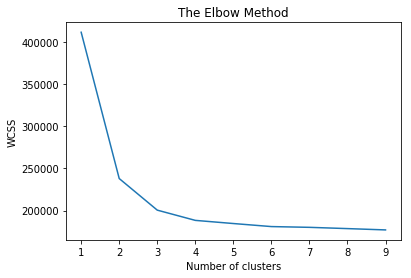

In [19]:
wcss = []
prevInert = 0
clusters = range(1,10)
for i in clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(np.array(allBooksBOW.drop(['sentenceFull','authorFull'], 1)))
    prevInert=kmeans.inertia_
    wcss.append(kmeans.inertia_)

plt.plot(clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [20]:
#forCols = allBooksBOW.drop(['sentence','author'])

X=allBooksBOW.drop(['sentenceFull','authorFull'],1)
cols = np.array(X.columns.values)
catCols = ['authorCode']
contCols = cols[cols!='authorCode']

numClusters = 3
kmeansParams = {'n_clusters': numClusters,
              'random_state': 42}

In [21]:
kmeansModel = ClusterModel('kmeans',X, KMeans(), catCols, contCols, **kmeansParams)

lables: [1 1 1 ..., 1 2 1]
lables: [0 0 0 ..., 0 0 0]
lables: [2 2 2 ..., 2 2 2]
lables: [1 2 0 ..., 0 0 0]


In [22]:
kmeansModel.silScore()

MEAN: 0.3469350771738938
RANGE: 0.00849929609450889
SCORES: [0.35060832394473695, 0.34210902785022806, 0.34676970317211769, 0.34825325372849258]


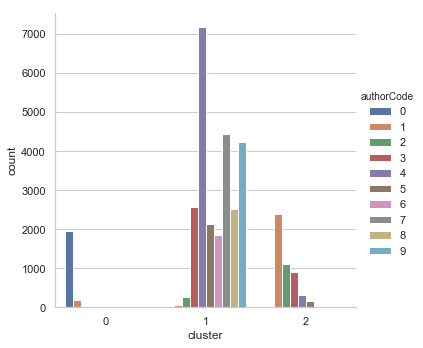

In [23]:
kmeansModel.showCatGraphs()

In [36]:
dict (enumerate (allBooksBOW.authorFull.cat.categories))

{0: 'austen',
 1: 'barrie',
 2: 'carroll',
 3: 'dickens',
 4: 'doyle',
 5: 'melville',
 6: 'shelley',
 7: 'stoker',
 8: 'twain',
 9: 'wilde'}

# tf-idf

In [24]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [29]:
allBksTfidf=vectorizer.fit_transform(sentencesAllBooks['sentence'])
print("Number of features: {}".format(allBksTfidf.get_shape()[1]))

Number of features: 9109


# Dimension Reduction

In [55]:
X_train, X_test = train_test_split(sentencesAllBooks['sentence'], test_size=0.4, random_state=42)

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(allBksTfidf, test_size=0.4, random_state=42)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Original sentence: here vague possibility
Tf_idf vector: {'free': 0.85811240380637466, 'know': 0.5134618802147296}


In [62]:
#Our SVD data reducer.  We are going to reduce the feature space to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Concept {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 28.2613039177
Concept 0:
sentence
say chuckle             0.982565
say sternly             0.982244
say doubtfully          0.981798
say equal politeness    0.981757
say gravely             0.981721
say                     0.981705
say                     0.981705
say                     0.981705
say                     0.981705
say                     0.981705
Name: 0, dtype: float64
Concept 1:
sentence
becuz know not anybody ghost use    0.861514
not know danger straight            0.856241
not know warm trifle                0.855127
not know aunt                       0.854905
not know value advice               0.854206
not know suffer                     0.852960
not know                            0.852575
not know                            0.852575
not know                            0.852575
not know                            0.852575
Name: 1, dtype: float64
Concept 2:
sentence
what loyalty fidelity lethargy custom lack imaginatio

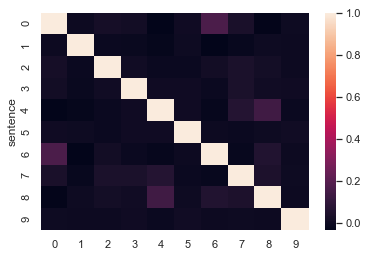

Key:
0 enter room corpse lie lead coffin
1 if
2 the son father secretary resign chief somewhat foolishly think time succeed month later title set study great aristocratic art absolutely
3 no likely attempt explain meet fate
4 sign listen
5 say let fool
6 as soon man enter dorian pull chequebook drawer spread
7 go find little difficulty wake woman
8 effect extraordinary hear mrs bennet sit unable utter syllable
9 well not know


In [52]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


0 and 6 are marked as similar. They both mention "entering".  4 and 8 are similar as well.  They both make reference to hearing. 

# Supervised Models

In [59]:
# random forest with tf idf
rfc = ensemble.RandomForestClassifier()

train = rfc.fit(X_train_tfidf, y_train)
print('Training set score:', rfc.score(X_train_tfidf, y_train))
print('Test set score:', rfc.score(X_test_tfidf, y_test))

Training set score: 0.934166365467
Test set score: 0.500619578686


In [63]:
# random forest with SVD 
rfc = ensemble.RandomForestClassifier()

train = rfc.fit(X_train_lsa, y_train)
print('Training set score:', rfc.score(X_train_lsa, y_train))
print('Test set score:', rfc.score(X_test_lsa, y_test))

Training set score: 0.934527805029
Test set score: 0.149318463445


In [69]:
# random forest with BOW
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.903134197346

Test set score: 0.445554522924


Random Forest using tf-idf features performed similarly to Random Forest for SVD on training data.  Both performed poorly on test data with SVD performing significantly worse.  Bag of Words features performed slightly worse than tf-idf features.  